# Feature Engineering with LGBM
해당코드는 [[Baseline] Random Forest](https://dacon.io/competitions/official/236125/codeshare/8492?page=1&dtype=recent)를 참조하였습니다.

## Import Libraries

In [1]:
import random
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb

## Fixed Random-Seed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data
- !data폴더 안에 데이터가 들어있습니다

In [3]:
train_origin = pd.read_csv('./data/train.csv')
test_origin = pd.read_csv('./data/test.csv')

In [6]:
building = pd.read_csv('./data/building_info.csv')

## Train Data Pre-Processing
- train 데이터를 20220820 기준으로 train/validation으로 분리해 사용하였습니다.
- validation 데이터의 score를 높이는 방향으로 모델을 search한 후 전체 train 데이터를 사용해 모델을 학습하고, test 데이터를 기반으로 예측해 최종 score를 제출하였습니다.

In [7]:
def train_test_split(df, th):
    train = df[df['일시'].str[:8].astype(int) < th].reset_index(drop=True)
    test = df[df['일시'].str[:8].astype(int) >= th].reset_index(drop=True)
    return train, test

In [8]:
def preprocess_x(df):
    to_remove_columns = ['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
    df = df.fillna(0)
    #시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
    df['month'] = df['일시'].apply(lambda x : int(x[4:6]))
    df['day'] = df['일시'].apply(lambda x : int(x[6:8]))
    df['time'] = df['일시'].apply(lambda x : int(x[9:11]))
    df = df.merge(building.iloc[:, :4])
    df['건물유형'] = df['건물유형'].astype('category').cat.codes
    for c in to_remove_columns:
        if c in df.columns:
            df = df.drop(columns=[c])
    return df

In [9]:
date_th = 20220820

In [10]:
train_df, valid_df = train_test_split(train_origin, date_th)
train_x = preprocess_x(train_df)
train_y = train_df['전력소비량(kWh)']

valid_x = preprocess_x(valid_df)
valid_y = valid_df['전력소비량(kWh)']

In [11]:
train_x.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),month,day,time,건물유형,연면적(m2),냉방면적(m2)
0,1,18.6,0.0,0.9,42.0,6,1,0,0,110634.0,39570.0
1,1,18.0,0.0,1.1,45.0,6,1,1,0,110634.0,39570.0
2,1,17.7,0.0,1.5,45.0,6,1,2,0,110634.0,39570.0
3,1,16.7,0.0,1.4,48.0,6,1,3,0,110634.0,39570.0
4,1,18.4,0.0,2.8,43.0,6,1,4,0,110634.0,39570.0


In [12]:
train_y.head()

0    1085.28
1    1047.36
2     974.88
3     953.76
4     986.40
Name: 전력소비량(kWh), dtype: float64

## Modeling
- LGBM모델을 사용하였으며, hyper parameter 튜닝은 따로 하지 않았습니다.

### 0. Functions For validation

In [17]:
def SMAPE(y, pred):
    smape = abs((y - pred))/((abs(y) + abs(pred)) / 2) * 100
    smape = np.mean(smape)
    return smape

def mae(y, pred):
    return np.mean(abs(y-pred))

In [18]:
def validate(valid_x, valid_y, model):
    pred = model.predict(valid_x)
    smape_score, mae_score = SMAPE(valid_y, pred), mae(valid_y, pred)
    return smape_score, mae_score

### 1. Base Model
- 주어진 데이터만을 사용해서 전체 학습데이터를 학습시켜 만든 모델입니다.
- validation score(SMAPE 기준)은 17.266입니다. 

In [15]:
model_lgb1 = lgb.LGBMRegressor(objective='regression', verbose=-1)
model_lgb1.fit(train_x, train_y)

LGBMRegressor(objective='regression', verbose=-1)

In [16]:
smape_score, mae_score = validate(valid_x, valid_y, model_lgb1)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 17.266317976699042
MAE: 370.7256803670178


#### 1-1. hyper parameter 조절
- n_estimators 값(학습을 얼마나 반복하냐이며 overfitting과 관련이 있음)을 조절해서 score가 어떻게 변화하는지 확인해봅시다.(default 값은 100)

In [19]:
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 17.266317976699042
MAE: 370.7256803670178


In [20]:
model_lgb2 = lgb.LGBMRegressor(objective='regression', n_estimators=50, verbose=-1)
model_lgb2.fit(train_x, train_y)

LGBMRegressor(n_estimators=50, objective='regression', verbose=-1)

In [21]:
smape_score, mae_score = validate(valid_x, valid_y, model_lgb2)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 20.592570387954538
MAE: 416.90878962419276


In [22]:
model_lgb3 = lgb.LGBMRegressor(objective='regression', n_estimators=300, verbose=-1)
model_lgb3.fit(train_x, train_y)

LGBMRegressor(n_estimators=300, objective='regression', verbose=-1)

In [23]:
smape_score, mae_score = validate(valid_x, valid_y, model_lgb3)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 15.798359023528862
MAE: 352.1086433302414


In [24]:
model_lgb4 = lgb.LGBMRegressor(objective='regression', n_estimators=500, verbose=-1)
model_lgb4.fit(train_x, train_y)

LGBMRegressor(n_estimators=500, objective='regression', verbose=-1)

In [25]:
smape_score, mae_score = validate(valid_x, valid_y, model_lgb4)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 15.88507529312217
MAE: 363.2452020120212


- n_estimators값이 300정도에서 모델 성능이 괜찮은 것을 확인할 수 있습니다.

## 2. Multi Models by building num
- 건물번호(1~100)별 모델을 각각 만들어 성능을 측정하였습니다.
- 건물별로 building_info값은 같기 때문에 해당 데이터는 제외했습니다(건물번호, 건물유형, 연면적, 냉방면적).

In [26]:
def validate_multi(valid_x, valid_y, models):
    """
    Args:
        models: dict, {1: model1, 2: model2, ..., 100: model100}
    """  
    preds = []
    for i in range(1, 101):
        _x = valid_x[valid_x['건물번호'] == i]
        _x = _x.drop(columns=['건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)'])
        pred = models[i].predict(_x).tolist()
        preds.extend(pred)
    preds = np.array(preds)
    smape_score, mae_score = SMAPE(valid_y, preds), mae(valid_y, preds)
    return smape_score, mae_score

In [27]:
def train_multiple_models(train_x, train_y, n_estimators=100):
    models = {}
    for i in tqdm(range(1, 101)):
        _x = train_x[train_x['건물번호'] == i]
        _x = _x.drop(columns=['건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)'])
        _y = train_y[_x.index]
        model_lgb = lgb.LGBMRegressor(objective='regression', n_estimators=n_estimators, verbose=-1)
        model_lgb.fit(_x, _y)
        models[i] = model_lgb
    return models

In [28]:
models1 = train_multiple_models(train_x, train_y)

100%|██████████| 100/100 [00:08<00:00, 11.83it/s]


In [40]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models1)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 13.771287702061969
MAE: 336.777787566924


#### 2-1 hyper parameter 조절
- 건물별 모델을 따로 만드는게 성능이 약간 더 좋았고(15.798 -> 13.13), multiple models의 경우 n_estimators를 작게 하는게 오히려 성능이 좋았습니다.
- 아마 모델별 데이터의 양이 작아져서 학습횟수를 크게하는게 과적합을 야기하는 것으로 생각됩니다.

In [41]:
models2 = train_multiple_models(train_x, train_y, 50)

100%|██████████| 100/100 [00:04<00:00, 21.50it/s]


In [42]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models2)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 13.134477105207413
MAE: 323.91722049143675


In [45]:
models3 = train_multiple_models(train_x, train_y, 300)

100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


In [46]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models3)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 14.462616029933997
MAE: 351.1786298329664


## 3. Add Features

### A. Weekday
- [가벼운 DATA EDA입니다.](https://dacon.io/competitions/official/236125/codeshare/8500?page=1&dtype=recent)에서 주말과 주중 전력사용량이 유의미한 차이를 보임을 확인할 수 있었습니다. 그래서 날짜를 이용해 요일데이터를 추출해 feature로 사용하였습니다.

In [47]:
import datetime

In [48]:
def to_datetime(s):
    """
    Args:
        s: ex) '20220601 01'
    Returns:
        weekday: 0~6(int), 0: 월요일, 1: 화요일, ...
    """
    s = s.split()[0]  # 20220601
    date = datetime.datetime.strptime(s, '%Y%m%d')
    weekday = date.weekday()  # 
    return weekday

In [49]:
train_origin_ = train_origin.copy()

In [50]:
train_origin_['Weekday'] = train_origin_.apply(lambda x:to_datetime(x['일시']), axis=1)

In [51]:
train_origin_.sample(5, random_state=42)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),Weekday
184895,91_20220724 23,91,20220724 23,23.8,NaN,0.3,99.0,NaN,NaN,474.00,6
187594,92_20220821 10,92,20220821 10,28.8,NaN,1.2,75.0,0.6,1.69,2012.94,6
119228,59_20220708 20,59,20220708 20,26.4,0.0,3.2,83.0,0.0,0.07,1265.76,4
148570,73_20220810 10,73,20220810 10,24.3,NaN,1.3,85.0,0.3,1.49,4114.08,2
150165,74_20220722 21,74,20220722 21,25.1,NaN,2.1,83.0,NaN,NaN,2900.16,4


In [52]:
# train, valid데이터 재생성
train_df, valid_df = train_test_split(train_origin_, 20220820)

train_x = preprocess_x(train_df)
train_y = train_df['전력소비량(kWh)']

valid_x = preprocess_x(valid_df)
valid_y = valid_df['전력소비량(kWh)']

In [53]:
models_f1 = train_multiple_models(train_x, train_y)

100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


In [54]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_f1)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 6.12057511177603
MAE: 122.03770909362358


#### A-1 hyper paramter 조절
- weekday 데이터를 추가하니 validation SMAPE score가 13.13 -> 5.97 까지 하락하였습니다.
- 참고로 해당 모델(validation score=5.976...)로 만든 submission을 dacon에 제출하였을때가 **best score였으며, score는 6.768이었습니다.**

In [55]:
models_f2 = train_multiple_models(train_x, train_y, 50)

100%|██████████| 100/100 [00:05<00:00, 19.83it/s]


In [56]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_f2)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 5.976245338538852
MAE: 118.11053878842343


In [57]:
models_f3 = train_multiple_models(train_x, train_y, 300)

100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


In [58]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_f3)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 6.31270884641306
MAE: 124.83480064258703


### B. 전날과의 기온, 풍속 차이
- 전 날과의 기온과 풍속, 습도의 차이값을 feature에 추가해보았습니다.
- weekday는 그대로 사용하였습니다(train_origin_)

In [59]:
train_origin_b = train_origin_.copy()

In [60]:
for i in range(1, 101):
    df = train_origin_b[train_origin_b['건물번호'] == i]
    train_origin_b.loc[df.index, '기온_gap'] = df['기온(C)'] - df.shift(1)['기온(C)']
    train_origin_b.loc[df.index, '풍속_gap'] = df['풍속(m/s)'] - df.shift(1)['풍속(m/s)']
    train_origin_b.loc[df.index, '습도_gap'] = df['습도(%)'] - df.shift(1)['습도(%)']

In [61]:
train_origin_b.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),Weekday,기온_gap,풍속_gap,습도_gap
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,2,NaN,NaN,NaN
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,2,-0.6,0.2,3.0
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88,2,-0.3,0.4,0.0
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76,2,-1.0,-0.1,3.0
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40,2,1.7,1.4,-5.0


In [62]:
train_origin_b['기온_gap'] = train_origin_b['기온_gap'].fillna(0)
train_origin_b['풍속_gap'] = train_origin_b['풍속_gap'].fillna(0)
train_origin_b['습도_gap'] = train_origin_b['습도_gap'].fillna(0)

In [63]:
train_df, valid_df = train_test_split(train_origin_b, 20220820)

train_x = preprocess_x(train_df)
train_y = train_df['전력소비량(kWh)']

valid_x = preprocess_x(valid_df)
valid_y = valid_df['전력소비량(kWh)']

In [64]:
train_x.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),Weekday,기온_gap,풍속_gap,습도_gap,month,day,time,건물유형,연면적(m2),냉방면적(m2)
0,1,18.6,0.0,0.9,42.0,2,0.0,0.0,0.0,6,1,0,0,110634.0,39570.0
1,1,18.0,0.0,1.1,45.0,2,-0.6,0.2,3.0,6,1,1,0,110634.0,39570.0
2,1,17.7,0.0,1.5,45.0,2,-0.3,0.4,0.0,6,1,2,0,110634.0,39570.0
3,1,16.7,0.0,1.4,48.0,2,-1.0,-0.1,3.0,6,1,3,0,110634.0,39570.0
4,1,18.4,0.0,2.8,43.0,2,1.7,1.4,-5.0,6,1,4,0,110634.0,39570.0


In [65]:
models_b1 = train_multiple_models(train_x, train_y)

100%|██████████| 100/100 [00:08<00:00, 12.10it/s]


In [66]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_b1)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 6.117250067250165
MAE: 122.69514615664708


#### B-1 hyper paramter 조절
- 그냥 weekday와 추가한 모델과 결과에서 큰 차이는 없었습니다.

In [67]:
models_b2 = train_multiple_models(train_x, train_y, 50)

100%|██████████| 100/100 [00:05<00:00, 19.94it/s]


In [68]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_b2)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 6.01702147440971
MAE: 120.5025427532366


In [69]:
models_b3 = train_multiple_models(train_x, train_y, 30)

100%|██████████| 100/100 [00:03<00:00, 32.18it/s]


In [70]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_b3)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 6.4078847129349406
MAE: 124.58726526813271


### C. 1주일 전 전력소모값
- test 데이터의 가장 마지막 날짜(8월31일)과 train 데이터의 가장 마지막 날짜(8월24일)의 gap이 7일이므로, test 데이터의 경우 과거 7일전 이상의 전력소모값은 접근할 수 있습니다.
- B에서 생성한 feature는 사용하지않고, weekday(train_origin_)만 사용하였습니다.

In [71]:
train_origin_c = train_origin_.copy()

In [72]:
n = 7*24 # 7*24시간 전 전력소모량
for i in range(1, 101):
    df = train_origin_c[train_origin_c['건물번호'] == i]
    train_origin_c.loc[df.index, f'{n}시간 전 전력소비량'] = df.shift(n)['전력소비량(kWh)']

In [73]:
train_df, valid_df = train_test_split(train_origin_c, 20220820)

train_x = preprocess_x(train_df)
train_y = train_df['전력소비량(kWh)']

valid_x = preprocess_x(valid_df)
valid_y = valid_df['전력소비량(kWh)']

In [74]:
train_x = train_x[train_x['168시간 전 전력소비량'] != 0]  # NaN이 0으로 replace되어 0이 아닌 row들 삭제
train_y = train_y[train_x.index]

In [75]:
train_x.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),Weekday,168시간 전 전력소비량,month,day,time,건물유형,연면적(m2),냉방면적(m2)
168,1,19.0,0.0,3.2,61.0,2,1085.28,6,8,0,0,110634.0,39570.0
169,1,18.8,0.0,2.6,61.0,2,1047.36,6,8,1,0,110634.0,39570.0
170,1,18.5,0.0,2.6,62.0,2,974.88,6,8,2,0,110634.0,39570.0
171,1,18.1,0.0,2.2,63.0,2,953.76,6,8,3,0,110634.0,39570.0
172,1,17.2,0.0,3.2,66.0,2,986.40,6,8,4,0,110634.0,39570.0


In [76]:
models_c1 = train_multiple_models(train_x, train_y)

100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


In [77]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_c1)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 7.5596222949098495
MAE: 165.4161695963737


In [78]:
models_c2 = train_multiple_models(train_x, train_y, 50)

100%|██████████| 100/100 [00:05<00:00, 19.85it/s]


In [79]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_c2)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 7.4665897355348365
MAE: 164.10137296168938


In [80]:
models_c3 = train_multiple_models(train_x, train_y, 300)

100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


In [81]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_c3)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 7.607725953289583
MAE: 165.62385860919687


- 오히려 score가 떨어졌습니다.

### D. 7일전 24시간동안의 전력소모량
- 8일전\~7일전(191시간전\~168시간전) 데이터를 feature로 추가해 사용해보았습니다.
- 위와 마찬가지로 weekday만 있는 모델에서 feature를 추가하였습니다.

In [82]:
train_origin_d = train_origin_.copy()

In [83]:
for i in range(1, 101):
    df = train_origin_d[train_origin_d['건물번호'] == i]
    fr, to = 7*24, 7*24+24
    for n in range(fr, to):
        train_origin_d.loc[df.index, f'{n}시간 전 전력소비량'] = df.shift(n)['전력소비량(kWh)']

In [84]:
train_df, valid_df = train_test_split(train_origin_d, 20220820)

train_x = preprocess_x(train_df)
train_y = train_df['전력소비량(kWh)']

valid_x = preprocess_x(valid_df)
valid_y = valid_df['전력소비량(kWh)']

In [85]:
train_x.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),Weekday,168시간 전 전력소비량,169시간 전 전력소비량,170시간 전 전력소비량,171시간 전 전력소비량,...,188시간 전 전력소비량,189시간 전 전력소비량,190시간 전 전력소비량,191시간 전 전력소비량,month,day,time,건물유형,연면적(m2),냉방면적(m2)
0,1,18.6,0.0,0.9,42.0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6,1,0,0,110634.0,39570.0
1,1,18.0,0.0,1.1,45.0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6,1,1,0,110634.0,39570.0
2,1,17.7,0.0,1.5,45.0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6,1,2,0,110634.0,39570.0
3,1,16.7,0.0,1.4,48.0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6,1,3,0,110634.0,39570.0
4,1,18.4,0.0,2.8,43.0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6,1,4,0,110634.0,39570.0


In [86]:
train_x = train_x[train_x['191시간 전 전력소비량'] != 0]  # NaN이 0으로 replace되어 0이 아닌 row들 삭제
train_y = train_y[train_x.index]

In [87]:
models_d1 = train_multiple_models(train_x, train_y)

100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


In [88]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_d1)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 8.09469887621692
MAE: 180.28542027333089


In [89]:
models_d2 = train_multiple_models(train_x, train_y, 50)

100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


In [90]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_d2)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 8.032829466393384
MAE: 179.66946544023767


In [91]:
models_d3 = train_multiple_models(train_x, train_y, 300)

100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


In [92]:
smape_score, mae_score = validate_multi(valid_x, valid_y, models_d3)
print(f'SMAPE: {smape_score}\nMAE: {mae_score}')

SMAPE: 8.16364752448132
MAE: 181.0440610249934


- feature를 추가하는게 오히려 성능을 떨어뜨림을 확인할 수 있습니다.

## Make Submission
- 전체 학습 데이터셋을 이용해 모델 생성
- 3-A(multiple models, add weekday)모델을 사용하였습니다.

In [93]:
submission = pd.read_csv('./data/sample_submission.csv')
submission

train_origin['Weekday'] = train_origin.apply(lambda x:to_datetime(x['일시']), axis=1)
test_origin['Weekday'] = test_origin.apply(lambda x:to_datetime(x['일시']), axis=1)
train_x_full = preprocess_x(train_origin)
train_y_full = train_origin['전력소비량(kWh)']

models = train_multiple_models(train_x_full, train_y_full)

100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


In [94]:
test_x_real = preprocess_x(test_origin)

In [95]:
preds_real = []
for i in tqdm(range(1, 101)):
    _x = test_x_real[test_x_real['건물번호'] == i]
    _x = _x.drop(columns=['건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)'])
    pred = models[i].predict(_x).tolist()
    preds_real.extend(pred)

100%|██████████| 100/100 [00:00<00:00, 348.54it/s]


In [96]:
submission['answer'] = preds_real

In [97]:
submission.head()

,num_date_time,answer
0,1_20220825 00,2101.314171
1,1_20220825 01,2083.573072
2,1_20220825 02,1963.799108
3,1_20220825 03,1946.555185
4,1_20220825 04,1963.741000


## 결론
- 건물별 100개의 모델을 따로 생성하고, weekday를 추가한 모델이 가장 좋은 성능을 보였습니다.
- validation score는 5.976, 실제 submission score는 6.76. 
- 두 값의 차이가 나는 이유는 best valiation score를 찾는 과정에서 약간의 overfitting이 발생하기도 했고, submssion에 사용하는 test 데이터의 설명변수(X)값들은 실제 값이 아닌 예측치라는 점도 영향을 미친것 같습니다.

## TODO
- 추가적인 feature를 고려해보았는데, 마땅히 떠오르는 아이디어가 없어서 모델의 hyper parameter 튜닝을 중점적으로 진행할 것 같습니다.
- 그리고 valid_y와 preds를 비교해 성능이 잘 안나오는 모델의 건물번호, 시간대 등을 분석해 모델을 보완해나가는게 필요할 것 같습니다.

## Epilog
- 3-A 모델에서 예측을 잘 못한 모델을 한번 뽑아봤습니다.

In [98]:
# train, valid데이터 재생성
train_df, valid_df = train_test_split(train_origin, 20220820)
train_x = preprocess_x(train_df)
train_y = train_df['전력소비량(kWh)']
valid_x = preprocess_x(valid_df)
valid_y = valid_df['전력소비량(kWh)']
models_f2 = train_multiple_models(train_x, train_y, 50)
preds = []
for i in range(1, 101):
    _x = valid_x[valid_x['건물번호'] == i]
    _x = _x.drop(columns=['건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)'])
    pred = models[i].predict(_x).tolist()
    preds.extend(pred)
preds = np.array(preds)

100%|██████████| 100/100 [00:02<00:00, 38.43it/s]


In [99]:
eda = valid_x.copy()
eda['pred'], eda['y'] = preds, valid_y
eda['gap'] = (eda['y'] - eda['pred']) / ((eda['y'] + eda['pred'])/2)  # SMAPE가 target이기 때문에 scale 고려

In [100]:
eda.sort_values('gap')

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),Weekday,month,day,time,건물유형,연면적(m2),냉방면적(m2),pred,y,gap
4987,42,26.1,0.0,1.6,72.0,0,8,22,19,4,97915.10,72000.00,1035.008805,541.08,-0.626778
4986,42,27.6,0.0,1.7,67.0,0,8,22,18,4,97915.10,72000.00,905.692356,550.08,-0.488555
6459,54,23.4,0.0,3.0,91.0,2,8,24,3,6,109400.20,65803.57,650.514168,439.92,-0.386257
1591,14,25.0,0.0,0.3,90.0,6,8,21,7,0,16844.16,14102.92,1329.121753,928.32,-0.355094
6458,54,23.6,0.0,2.2,93.0,2,8,24,2,6,109400.20,65803.57,633.834055,451.08,-0.336901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8805,74,28.1,0.0,2.0,75.0,6,8,21,21,8,253743.00,142705.00,3642.572193,4785.12,0.271141
8812,74,25.7,0.0,1.5,83.0,0,8,22,4,8,253743.00,142705.00,3852.163705,5207.04,0.299116
4989,42,24.6,0.0,0.6,73.0,0,8,22,21,4,97915.10,72000.00,309.401572,437.76,0.343589
4990,42,24.5,0.0,0.9,73.0,0,8,22,22,4,97915.10,72000.00,266.916125,399.96,0.399006


In [101]:
bads = eda.groupby('건물번호').agg(lambda x:np.mean(abs(x))).sort_values('gap').tail(5)
goods = eda.groupby('건물번호').agg(lambda x:np.mean(abs(x))).sort_values('gap').head(5)

In [102]:
bads

,기온(C),강수량(mm),풍속(m/s),습도(%),Weekday,month,day,time,건물유형,연면적(m2),냉방면적(m2),pred,y,gap
건물번호,,,,,,,,,,,,,,
40,26.818333,0.494167,0.964167,91.808333,2.8,8.0,22.0,11.5,4.0,58483.00,40775.00,2026.925071,2024.4925,0.048773
54,25.380000,0.458333,2.947500,77.383333,2.8,8.0,22.0,11.5,6.0,109400.20,65803.57,1908.263815,1909.7040,0.051798
42,25.225833,0.735000,1.030000,79.366667,2.8,8.0,22.0,11.5,4.0,97915.10,72000.00,1451.465178,1445.1360,0.057179
14,25.757500,0.023333,2.500000,75.675000,2.8,8.0,22.0,11.5,0.0,16844.16,14102.92,1773.605859,1765.2360,0.072111
95,24.460833,0.317500,0.871667,85.941667,2.8,8.0,22.0,11.5,11.0,196992.54,57022.55,1108.409362,1101.7530,0.091829


In [103]:
goods

,기온(C),강수량(mm),풍속(m/s),습도(%),Weekday,month,day,time,건물유형,연면적(m2),냉방면적(m2),pred,y,gap
건물번호,,,,,,,,,,,,,,
33,26.700833,0.046667,2.173333,74.983333,2.8,8.0,22.0,11.5,3.0,28059.00,20397.00,8779.872825,8780.154,0.001261
32,26.700833,0.046667,2.173333,74.983333,2.8,8.0,22.0,11.5,3.0,35300.00,14687.00,9894.715410,9895.170,0.001552
35,26.700833,0.046667,2.173333,74.983333,2.8,8.0,22.0,11.5,3.0,9736.00,6070.00,2184.464302,2184.585,0.001730
36,26.195833,0.080833,1.727500,80.966667,2.8,8.0,22.0,11.5,3.0,8816.49,8816.49,2897.108527,2898.290,0.001996
58,26.195833,0.080833,1.727500,80.966667,2.8,8.0,22.0,11.5,6.0,14897.00,7071.92,2898.319542,2898.372,0.002272


- 95, 14번 건물 모델이 성능이 잘 안나왔고, 33, 32번 건물 모델 성능이 잘나왔네요.
- 95, 14번처럼 매 시각마다 전력사용량이 크게 바뀌는 건물의 경우 좀더 복잡한 모델을 사용하는게 점수가 잘나올 듯 합니다.

<Axes: >

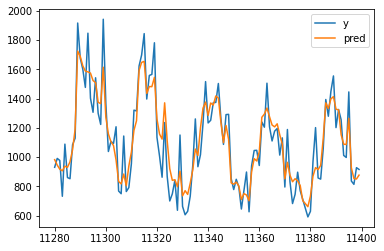

In [104]:
eda[eda['건물번호']==95][['y', 'pred']].plot()

<Axes: >

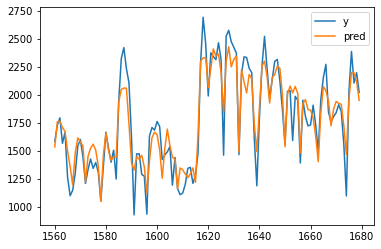

In [105]:
eda[eda['건물번호']==14][['y', 'pred']].plot()

<Axes: >

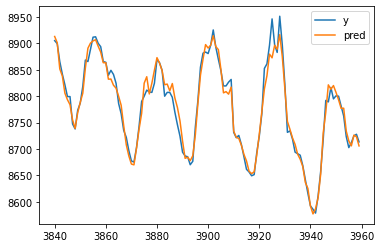

In [106]:
eda[eda['건물번호']==33][['y', 'pred']].plot()

<Axes: >

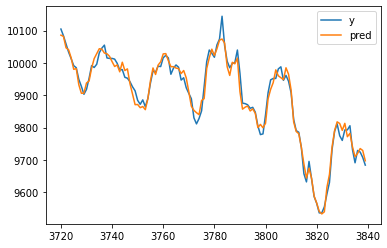

In [107]:
eda[eda['건물번호']==32][['y', 'pred']].plot()